# k-NN


**Implementation of k nearest neighbors algorithm from scratch, incl. normalization and cross-validation**

I will use the [Boston Housing Prices Data Set](http://www.kellogg.northwestern.edu/faculty/weber/emp/_session_3/boston.htm).  to test the k-NN implementation.

**Part 1.** - define objective, evaluation metric and benchmark for the Boston housing prices data set <br>
**Part 2.** - implement k-NN with normalization and cross validation, then use hyperparameter tuning <br>
**Part 3.** - implement feed-forward selection to automatically select best features using cross validation

In [111]:
# import some useful libraries...

import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn

## Data

In [112]:
from sklearn.datasets import load_boston
bdata = load_boston()

## 1. Experimental Setup
We start by defining what we want to achieve, how we are going to measure success and by creating a benchmark to measure how much we are improving versus, in this case, a very naive/simple approach.

**[...] Objective**: Predict the median home value of a home <br>
**[1.1] Evaluation metric**: RMSE <br>
**[1.2] Benchmark**: average median value of dataset 

### 1.1 Evaluation metric

In [2]:
"""
Function
--------
compute_rmse

Given two arrays, one of actual values and one of predicted values,
compute the Root Mean Squared Error

Parameters
----------
predictions : array
    Array of numerical values corresponding to predictions for each of the N observations

yvalues : array
    Array of numerical values corresponding to the actual values for each of the N observations

Returns
-------
rmse : int
    Root Mean Squared Error of the prediction

Example
-------
>>> print(compute_rmse(2,2,3),(0,2,6)))
2.08
"""
def compute_rmse(predictions, yvalues):
    x = float(np.sqrt(sum((np.subtract(predictions, yvalues))**2)*(1/len(predictions))))
    return round(x,2)

compute_rmse([2,2,3],[0,2,6])



    

2.08

### 1.2 Benchmark

For a very simple benchmark I will predict the average median home value of the complete dataset for every individual instance. For completeness sake I'll split the data in a training and test set. I would not expect the RMSE to be significantly different from each other though.  In fact, with a random test/train split you would expect the RMSE on both samples to be the same on average. 


### 1.2.1 Train test split

In [113]:
# Use seed for reproducibility of results
np.random.seed(seed=13579)

# Create dataframe with full boston dataset (features + target)

df_features = pd.DataFrame(data = bdata.data, columns = bdata.feature_names)               
df_target = pd.DataFrame(bdata.target,columns = ['MedianValue'])
df_boston = pd.concat([df_features, df_target], axis = 1)

# Randomly select train and test based on index of bdata

def train_test_split(df, split_percentage=0.8):
    train_index = np.random.choice(df.index, size = int(split_percentage*len(df.index)), replace = False)
    test_index = df.index[~df.index.isin(train_index)]
    
    bdata_train = df.iloc[train_index]
    bdata_test = df.iloc[test_index]
    
    return bdata_train, bdata_test
    
bdata_train, bdata_test = train_test_split(df_boston, split_percentage=0.8)


print(bdata_train.shape)
print(bdata_test.shape)

(404, 14)
(102, 14)


### 1.2.2. Create a very simple baseline and compute RMSE

RMSE training set:  9.21
RMSE test set:  9.11
Time taken: 0.0000000000 seconds


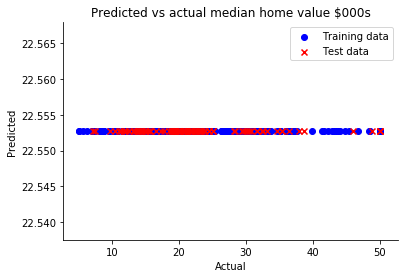

In [5]:
## Create baseline performance
import time

# RMSE of training set

yhat_list = np.asarray([bdata_train['MedianValue'].mean()]*len(bdata_train))
RMSE_base_training = compute_rmse(yhat_list, bdata_train['MedianValue'].values)
print('RMSE training set: ', RMSE_base_training)


# RMSE of test data + added timer

start = time.time()
yhat_list2 = np.asarray([bdata_train['MedianValue'].mean()]*len(bdata_test))
end = time.time()

RMSE_base_test = compute_rmse(yhat_list2, bdata_test['MedianValue'])

print('RMSE test set: ', RMSE_base_test)
print("Time taken: {:.10f} seconds".format(end - start))

## Visualize results
# Scatterplot

fig, ax = plt.subplots()
ax.scatter(bdata_train['MedianValue'], yhat_list, color = ['blue'], marker = 'o', label = 'Training data')
ax.scatter(bdata_test['MedianValue'], yhat_list2, color = ['red'], marker = 'x', label = 'Test data')

plt.title('Predicted vs actual median home value $000s')
plt.ylabel('Predicted')
plt.xlabel('Actual')

ax.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()



### Observations:
* The RMSE of the train and test set are indeed very close to each other
* This is obviously a terrible model. Hopefuly I can do a lot better than this :)

## 2. Implement k-Nearest Neighbors

To implement k-NN, I'll first build the building blocks for the algorithm and then use cross-validation to tune the most relevant hyper parameter k. The implementation steps:

**[2.1] A flexible/fast distance function**: k-NN has 0 training time but can be slow at run time. A fast distance function is important, since this is the 'engine' of the prediction. I include a flexible L-norm as a potential hyper parameter  <br>
**[2.2] Normalization**:  Normalization is very important for k-NN since the distance function will be impacted by scale of the variables <br> 
**[2.3] Cross-validation**:  Cross-validation is important to get a robust sense of hyper parameter tuning effectiveness and final algorith mperformance <br>
**[2.4] Hyper parameter tuning**: Use cross-validation to get the optimal value for k 

### 2.1 Algorithm - Distance function

In [54]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print(distance((3,4),(6,8),2))
5

"""

def distance(x1, x2, L=2):
    
    dist = np.sum(abs(np.subtract(x1,x2))**L)
    dist = dist**(1/L)
    return dist

print(distance((3,4),(6,8),2))

5.0


### 2.2 Options - Normalization 

In [74]:
"""
Function
--------
normalize

Given an array of values, subtract the mean, then divide by the standard deviation to get normalized values

Parameters
----------
raw_data: list or array or tuple
    Data to be normalized

Returns
-------
normalized_data : list or array or tuple
    Normalized data

Example
-------
>>> print(normalize((50, -50, 24, -18)))
[ 1.26379672, -1.34196971,  0.58629745, -0.50812445]
"""
def normalize(raw_data):
    data_mean = np.mean(raw_data)
    data_std = np.std(raw_data)
    normalized_data = (raw_data - data_mean)/data_std
    return normalized_data

print(normalize((50, -50, 24, -18)))

[ 1.26379672 -1.34196971  0.58629745 -0.50812445]


### 2.3.1 k-NN
First I'll define k-NN, without the normalization and cross validation options (just to focus on the k-NN code) <br>
I'll use a random selection of variables first, but use Forward selection in section 3 to optimize the features

In [79]:
"""
Function
---------
Nearest Neighbor

Given a training set and a test set, predict the median home value of each instance in the test set 
and return the RMSE of predicted vs. actual and the time it took to calculate

Parameters
-----------
df_test, df_train: DataFrame 
    DataFrames of test and training instances
    
features: array
    Selection of features you want to include
    
K: int
    value for k in k-NN, i.e. how many closest neighbors do use for output

L: int
    Value for L-distance
   
Returns
--------
df_test_output: DataFrame
    Original test dataframe with predicted values for median house value

Example
--------
>>> print nneighbor(df_test, df_train, ['CRIM', 'RM'], 2, 3)
[dataframe]


"""

import time
def nneighbor(df_test, df_train, features = ['CRIM', 'RM'], k = 3, L = 2):
    start_time = time.time()
    
    # Copy dataframe as template to create output
    df_test_output = df_test.copy(deep=True)
    df_test_output['yhat'] = 0.0
    df_train_input = df_train.copy(deep=True)

    # Create df with specified features
    df_train_sub = df_train[features]
    df_test_sub = df_test[features]
     
    # Apply distance function on all train rows, for every single test row
    d = np.array([distance(x1, x2, L) for x1 in df_test_sub.values for x2 in df_train_sub.values ])
    
    # Cut list of distances into equal lenght chunks of size of train rows
    def chunks(d, n):
        n = max(1, n)
        return (d[i:i+n] for i in range(0, len(d), n))

    c = chunks(d, len(df_train_sub))
    
    # Create DataFrame with distance chunks, one column per test instance. Row/Col names are original indices
    df_dist = pd.DataFrame(data = c).T  # Have to transpose because I want each chunk to be a column, not row
    
    # Convert distances values in df to sorted list of indices (iloc) of length k
    df_dist_iloc = df_dist.apply(np.argsort, axis = 0)[:k]
    
    # Convert iloc values to k-NN median house values
    def get_yhats(indices):
        return df_train_input['MedianValue'].iloc[indices].values

    yhats = df_dist_iloc.apply(get_yhats, axis = 1)
    yhats_mean = yhats.mean()                           # Calculates mean over each column

    # Fill yhat column with predictions
    df_test_output['yhat'] = yhats_mean.values
    
    MEDV_p = df_test_output['yhat']
    rmse = compute_rmse(df_test_output['yhat'], df_test_output['MedianValue'])
    end_time = time.time()
    print("Time taken: {:.5f} seconds".format(end_time - start_time))
    print('RMSE', rmse)
    return df_test_output

print('Test set')
df_test_result = nneighbor(bdata_test, bdata_train, features = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX'], k = 1, L = 2)
print()
print('Training set')
df_train_result = nneighbor(bdata_train, bdata_train, features = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX'], k = 1, L = 2)

Test set
Time taken: 0.36590 seconds
RMSE 9.64

Training set
Time taken: 1.35361 seconds
RMSE 0.0


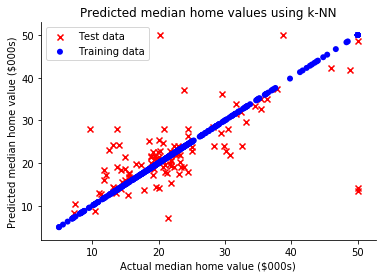

In [58]:
# Scatterplot

fig, ax = plt.subplots();
ax.scatter(df_test_result['MedianValue'], df_test_result['yhat'], c='red', edgecolor='none', marker='x', label='Test data')
ax.scatter(df_train_result['MedianValue'], df_train_result['yhat'], c='blue', edgecolor='none', marker='o', label='Training data')

plt.xlabel('Actual median home value ($000s)')
plt.ylabel('Predicted median home value ($000s)')
plt.title('Predicted median home values using k-NN')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.legend()

plt.show()

### 2.3.2 k-NN with normalization

In [102]:
"""
Function
---------
Nearest Neighbor, with added options

Given a dataset, predict the median home value of each instance based on its k-nearest neighbors 
and return the cross-validated RMSE


Parameters
-----------
df: DataFrame 
    DataFrames of instances
    
features: array
    Selection of features you want to include
    
K: int
    value for k in k-NN, i.e. how many closest neighbors do use for output

L: int
    Value for L-distance

normalize: int
    1/0 value to indicate whether to normalize

folds: int
    Number of folds for cross-validation. 
    
   
Returns
--------
df_test_OG: DataFrame
    Original test dataframe with predicted values for MEDV

Example
--------
>>> print nneighbor(bdata_test, bdata_train, ['CRIM', 'RM'], 2, 3)
[dataframe]


"""

def nneighbor_norm(df_test, df_train, features = ['CRIM', 'RM'], k = 3, L = 2, norm = 1):
    start_time = time.time()
      
    # Copy dataframe as template to create output
    df_test_output = df_test.copy(deep=True)
    df_test_output['yhat'] = 0.0
    df_train_input = df_train.copy(deep=True)

    # Create df with specified features
    if norm == 1:
        df_train_sub = df_train[features].apply(normalize)
        df_test_sub = df_test[features].apply(normalize)
    else:
        df_train_sub = df_train[features]
        df_test_sub = df_test[features]
           
    # Apply distance function on all train rows, for every single test row
    d = np.array([distance(x1, x2, L) for x1 in df_test_sub.values for x2 in df_train_sub.values ])
    
    # Cut list of distances into equal lenght chunks of size of train rows
    def chunks(d, n):
        n = max(1, n)
        return (d[i:i+n] for i in range(0, len(d), n))

    c = chunks(d, len(df_train_sub))
    
    # Create DataFrame with distance chunks, one column per test instance. Row/Col names are original indices
    df_dist = pd.DataFrame(data = c).T  # Have to transpose because I want each chunk to be a column, not row
    
    # Convert distances values in df to sorted list of indices (iloc) of length k
    df_dist_iloc = df_dist.apply(np.argsort, axis = 0)[:k]
    
    # Convert iloc values to k-NN median house values
    def get_yhats(indices):
        return df_train_input['MedianValue'].iloc[indices].values

    yhats = df_dist_iloc.apply(get_yhats, axis = 1)
    yhats_mean = yhats.mean()                           # Calculates mean over each column

    # Fill yhat column with predictions
    df_test_output['yhat'] = yhats_mean.values
    
    MEDV_p = df_test_output['yhat']
    rmse = compute_rmse(df_test_output['yhat'], df_test_output['MedianValue'])
    end_time = time.time()
    print("Time taken: {:.5f} seconds".format(end_time - start_time))
    print('RMSE', rmse)
    return rmse

print('Test set')
df_test_result = nneighbor_norm(bdata_test, bdata_train, features = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX'], k = 1, L = 2, norm = 1)
print()
print('Training set')
df_train_result = nneighbor_norm(bdata_train, bdata_train, features = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX'], k = 1, L = 2, norm = 1)
        
   

Test set
Time taken: 0.42781 seconds
RMSE 7.68

Training set
Time taken: 1.35901 seconds
RMSE 0.0


### 2.3.3 k-NN with normalization and cross-validation

In [107]:
def nneighbor_norm_xval(df, features, k=3, L=2, norm = 1, folds=10):
    start_time = time.time() 
    
    # Create random list of indices, divide into folds
    xval_index = np.random.choice(df.index, size = df.shape[0], replace=False)  
    xval_folds = np.array(np.array_split(xval_index, folds)) #using array_split b/c np.split needs exact size folds
    
    # Create list for rmse to fill later
    rmse_list = []
    
    # Create test set (the first set of indices), then have other indices be train set. Repeat i-fold times
    for i in np.arange(len(xval_folds)):
        xval_test = df.iloc[xval_folds[i]]  
        xval_train = df[~df.isin(xval_test)].dropna()
        
        # Run k-NN for all folds
        rmse = nneighbor_norm(xval_test, xval_train, features, k, L, norm = norm)  
        rmse_list = np.append(rmse_list, rmse) 
        print('Fold ', i+1)
        print()
    
    rmse_mean = (sum(rmse_list)/len(rmse_list))
    end_time = time.time()
    print("Total time taken: {:.5f} seconds".format(end_time - start_time))
    print('Average RMSE across iterations: {:.2f}'.format(rmse_mean))
    return rmse_mean


In [119]:

nneighbor_norm_xval(df_boston, features = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX'], k = 1, L = 2, norm = 1, folds = 10)

Time taken: 0.32151 seconds
RMSE 7.47
Fold  1

Time taken: 0.21250 seconds
RMSE 4.4
Fold  2

Time taken: 0.22350 seconds
RMSE 5.07
Fold  3

Time taken: 0.22500 seconds
RMSE 6.1
Fold  4

Time taken: 0.25151 seconds
RMSE 9.77
Fold  5

Time taken: 0.22500 seconds
RMSE 5.41
Fold  6

Time taken: 0.28551 seconds
RMSE 3.91
Fold  7

Time taken: 0.24000 seconds
RMSE 6.1
Fold  8

Time taken: 0.27350 seconds
RMSE 9.14
Fold  9

Time taken: 0.25001 seconds
RMSE 6.6
Fold  10

Total time taken: 2.61155 seconds
Average RMSE across iterations: 6.40


6.3970000000000002

### Observations:
* k-NN without normalization performs worse than our benchmark with an rmse of 9.64 vs. 9.11! That's impressive .. The different scales of the various features impart a random weighting on each variable, which can hurt performance. In this dataset, values can differ up to a factor of 120 (!)
* I used k=1, so the training rmse is 0, since every training instance is matched with itself. For k >1 the algorithm will take an average of median house value of the k closest neighbors
* k-NN with normalization outperforms the benchmark with an rmse of 7.68
* Cross-validation shows just how important cross-validation is. The average rmse with normalization is 6.39, but individual rmse's for each of the 10 range from ~4 to ~9

### 2.4 Use cross-validation to find K

To find the best choice for k, I will compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  We'll use a randomly chosen set of features for now, but I will implement forward selection in the next section to optimize for features as well

In [14]:
# Create dictionary for K values
k_dict = {}

# Run for values of K between 1 and 25, using 10-fold xval
for n in np.arange(1,26):
    k_dict[n] = nneighbor_xval(df_boston, features = ['CRIM', 'ZN', 'RM', 'AGE', 'DIS', 'TAX'] ,\
                                          k = n, L = 2, folds = 10) 
    print ('Average RMSE', n, ':' , k_dict[n])


Time taken: 0.22241 seconds
RMSE 4.77
Time taken: 0.19460 seconds
RMSE 4.86
Time taken: 0.20141 seconds
RMSE 9.11
Time taken: 0.18720 seconds
RMSE 8.17
Time taken: 0.20521 seconds
RMSE 6.37
Time taken: 0.20361 seconds
RMSE 3.96
Time taken: 0.20840 seconds
RMSE 9.43
Time taken: 0.21181 seconds
RMSE 4.34
Time taken: 0.19400 seconds
RMSE 5.97
Time taken: 0.19800 seconds
RMSE 8.53
Average RMSE 1 : 6.551
Time taken: 0.18820 seconds
RMSE 3.74
Time taken: 0.21300 seconds
RMSE 4.48
Time taken: 0.18240 seconds
RMSE 5.38
Time taken: 0.19340 seconds
RMSE 6.26
Time taken: 0.19420 seconds
RMSE 6.0
Time taken: 0.20760 seconds
RMSE 3.19
Time taken: 0.20500 seconds
RMSE 9.59
Time taken: 0.22001 seconds
RMSE 3.77
Time taken: 0.20501 seconds
RMSE 4.42
Time taken: 0.20501 seconds
RMSE 8.05
Average RMSE 2 : 5.488
Time taken: 0.29422 seconds
RMSE 3.44
Time taken: 0.22920 seconds
RMSE 4.34
Time taken: 0.23600 seconds
RMSE 4.66
Time taken: 0.29601 seconds
RMSE 6.77
Time taken: 0.26602 seconds
RMSE 5.71
Time 

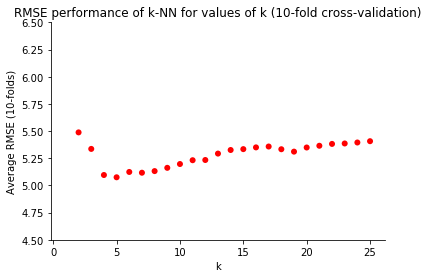

In [15]:
# Create a graph that shows how RMSE changes as K increases from 1 to 25. 

fig, ax = plt.subplots();

ax.scatter(list(k_dict.keys()), list(k_dict.values()), c='red', edgecolor='none', marker='o') 

plt.title('RMSE performance of k-NN for values of k (10-fold cross-validation)')
plt.xlabel('k')
plt.ylabel('Average RMSE (10-folds)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

ax.set_ylim(4.5,6.5)

plt.show()


**Observations:**
 * Based on the chart I would go for a k of 5.
     * At lower values of K you see the effect of overfitting on train, producing higher RMSE on test
     * At very high values of K you see that you are starting to underfit and test RMSE starts to trends higher
     * The value at k = 5 is lowest and this seems to be where the trend between over/underfitting reverses direction. (there is probably noise in there, so any k in a range of say 4-6 should do)
 * The cross-validated (average) rmse for k = 5 is 5.075, which comfortably beats our benchmark of 9.11. This means that the predictions of k-NN are on average ~$4000 closer to the actual median home value.

## 3. Implement Forward selection

Thus far the choice of features to include in the model has been arbitrary. To improve on that I will implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. The optimal value of K may be different for each model, so I will use cross-validation to choose the best k each time.

In [129]:
# WIP
# For loop with all features, cross-validate and choose best k, choose best feature
# For loop with that feature and rest of features ... keep each feature that lowers rmse
# iterate
# choose

feature_list = bdata.feature_names
final_features = [] 
rmses_per_k = []


for i in feature_list:
    for n in np.arange(1,2):
        rmse_temp = nneighbor_norm_xval(df_boston, features = i, k = n, L = 2, norm = 1, folds = 10)
        rmses_per_k = np.append(rmses_per_k, rmse_temp)
        np.min(rmses_per_k)
        np.argmin(rmses_per_k)
    

Time taken: 0.33602 seconds
RMSE 13.18
Fold  1

Time taken: 0.33302 seconds
RMSE 14.72
Fold  2

Time taken: 0.30702 seconds
RMSE 13.43
Fold  3

Time taken: 0.31702 seconds
RMSE 14.45
Fold  4

Time taken: 0.31502 seconds
RMSE 11.78
Fold  5

Time taken: 0.31302 seconds
RMSE 14.95
Fold  6

Time taken: 0.31502 seconds
RMSE 13.36
Fold  7

Time taken: 0.30402 seconds
RMSE 13.23
Fold  8

Time taken: 0.31302 seconds
RMSE 16.72
Fold  9

Time taken: 0.32702 seconds
RMSE 9.68
Fold  10

Total time taken: 3.25119 seconds
Average RMSE across iterations: 13.55
Time taken: 0.33902 seconds
RMSE 12.84
Fold  1

Time taken: 0.32502 seconds
RMSE 11.48
Fold  2

Time taken: 0.31202 seconds
RMSE 14.24
Fold  3

Time taken: 0.32802 seconds
RMSE 16.83
Fold  4

Time taken: 0.32202 seconds
RMSE 13.85
Fold  5

Time taken: 0.34502 seconds
RMSE 8.76
Fold  6

Time taken: 0.32102 seconds
RMSE 12.95
Fold  7

Time taken: 0.35402 seconds
RMSE 15.54
Fold  8

Time taken: 0.37302 seconds
RMSE 12.9
Fold  9

Time taken: 0.3210